### HOOMD hard disks MC simulation

In [45]:
import hoomd
from hoomd import hpmc

In [46]:
hoomd.context.initialize('')

In [47]:
import numpy as np
phi = 0.706 # packing fraction
sigma = 1
N = 1024
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5

In [48]:
box = hoomd.data.boxdim(L=L,dimensions=2)
snap = hoomd.data.make_snapshot(N=N,particle_types=['A'],box=box)
a = L/np.sqrt(N)
snap.particles.position[:] = [(i,j,0) for i in np.arange(-L/2,L/2,a) for j in np.arange(-L/2,L/2,a)]

In [49]:
system = hoomd.init.read_snapshot(snap)

notice(2): Group "all" created containing 1024 particles


In [50]:
# for i in system.particles:
#     i.position = (1,2,0)

In [51]:
# for i in system.particles:
#     print(i.position)

In [52]:
mc = hpmc.integrate.sphere(seed=123)

In [53]:
sigma=1
mc.shape_param.set('A',diameter=sigma)

In [54]:
gsd = hoomd.dump.gsd('trajectory_1024_706_100k.gsd',period=1,group=hoomd.group.all(),overwrite=True)

In [55]:
mc.set_params(d=0.05)

In [56]:
hoomd.run(100000)

** starting run **
Time 00:00:19 | Step 5168 / 100000 | TPS 516.772 | ETA 00:03:03
Time 00:00:29 | Step 10299 / 100000 | TPS 513.099 | ETA 00:02:54
Time 00:00:39 | Step 15391 / 100000 | TPS 509.171 | ETA 00:02:46
Time 00:00:49 | Step 20419 / 100000 | TPS 502.77 | ETA 00:02:38
Time 00:00:59 | Step 22972 / 100000 | TPS 255.256 | ETA 00:05:01
Time 00:01:09 | Step 27979 / 100000 | TPS 500.672 | ETA 00:02:23
Time 00:01:19 | Step 32979 / 100000 | TPS 499.886 | ETA 00:02:14
Time 00:01:29 | Step 37956 / 100000 | TPS 497.662 | ETA 00:02:04
Time 00:01:39 | Step 43108 / 100000 | TPS 515.122 | ETA 00:01:50
Time 00:01:49 | Step 47830 / 100000 | TPS 472.156 | ETA 00:01:50
Time 00:01:59 | Step 52895 / 100000 | TPS 506.489 | ETA 00:01:33
Time 00:02:09 | Step 57947 / 100000 | TPS 505.2 | ETA 00:01:23
Time 00:02:19 | Step 62893 / 100000 | TPS 494.599 | ETA 00:01:15
Time 00:02:29 | Step 67540 / 100000 | TPS 464.616 | ETA 00:01:09
Time 00:02:39 | Step 72430 / 100000 | TPS 488.924 | ETA 00:00:56
Time 00:02

In [57]:
snap = system.take_snapshot()

In [58]:
def plot_config(pts,L=1):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    circles = [plt.Circle(p,.5) for p in pts]
    for c in circles:
        ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)

In [59]:
import matplotlib.pyplot as plt
def plot_config_wrap(pts,L=1,title=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    pts_addl = []
    for p in pts:
        if p[0] < -L/2+0.5:
            pts_addl.append([p[0]+L, p[1]])  
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]-L])
        if p[0] > -L/2+0.5:
            pts_addl.append([p[0]-L, p[1]])
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]-L])
        if p[1] < -L/2+0.5:
            pts_addl.append([p[0], p[1]+L])
        if p[1] > -L/2+0.5:
            pts_addl.append([p[0], p[1]-L])
        
    circles = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts]
    circles2 = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts_addl]
    for c in circles:
        ax.add_patch(c)
    for c in circles2:
        ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)
    if title is not None:
        ax.set_title(title)

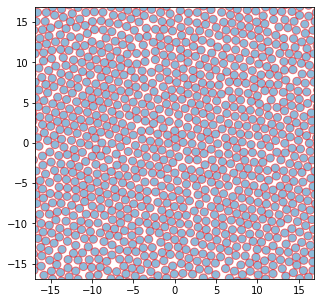

In [60]:
pts = snap.particles.position[:]
plot_config_wrap(pts,L=system.box.Lx)

### Invertible network for hard particles

In [61]:
# Maximum likelihood in z
import tensorflow as tf
def loss_z(inv_net):
    return -inv_net.log_likelihood_z_normal()

In [50]:
import tensorflow as tf
def loss_x(inv_net):
    x = inv_net.output_x
    f = inv_net.overlap_model.smooth_overlap_tf(x)
    #return tf.where(f>0,tf.math.log(f)-inv_net.log_det_Jzx[:,0],0)
    #return f*tf.math.exp(-inv_net.log_det_Jzx[:,0])
    return f-inv_net.log_det_Jzx[:,0]
    #return f*tf.math.exp(-inv_net.log_det_Jzx[:,0])
    

In [51]:
import tensorflow.keras as keras
import tensorflow as tf
from deep_boltzmann.networks.invertible import InvNet

class OverlapInvNet(InvNet):

    def __init__(self, overlap_model, layers):
        """ Invertible net where we have an overlap function (==0 or 1) that defines p(x)
            and the prior is the uniform on the interval [a,b)"""
        self.overlap_model = overlap_model
        super().__init__(overlap_model.dim, layers, prior='normal')
        
        self.Tzx.add_loss(loss_x(self))
        self.Txz.add_loss(loss_z(self))
        
    @classmethod
    def load(cls, filename, energy_model):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        keras.backend.clear_session()
        D = load_obj(filename)
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

    def weight(self):
        """ Computes the reweighting factor
        """
        z = self.input_z
        x = self.output_x
        # compute overlap property
        f = self.overlap_model.smooth_overlap_tf(x)
        weight = tf.math.exp(self.log_det_Jzx[:, 0])
        return weight

    def sample(self, nsample=100000, temperature=1.0):
        """ Samples from prior distribution in z and produces generated x configurations

        Parameters:
        -----------
        temperature : float
            Relative temperature. Equal to the variance of the isotropic Gaussian sampled in z-space.
        nsample : int
            Number of samples

        Returns:
        --------
        sample_z : array
            Samples in z-space
        sample_x : array
            Samples in x-space
        weight_z:
            Weight of z samples
        overlap_x : array
            Overlap property of x samples
        w : array
            Weight of samples

        """

        sample_z, energy_z = self.sample_z(nsample=nsample, return_energy=True, temperature=temperature)

        sample_x, Jzx = self.transform_zxJ(sample_z)
        overlap_x = self.overlap_model.smooth_overlap_tf(sample_x).numpy()
        print(overlap_x)
        w = np.exp(Jzx)
        logw = overlap_x + energy_z + Jzx

        return sample_z, sample_x, energy_z, overlap_x, w, logw

    
    def train_z(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Txz.compile(optimizer)

        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        hist = self.Txz.fit(x=x, validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist
    
    def train_x(self, optimizer=None, lr=0.001, batches=1,epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
                
        self.Tzx.compile(optimizer)

        x = self.sample_z(nsample=batches*batch_size, return_energy=False)
        hist = self.Tzx.fit(x=x,batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

    def train_both(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.Adam(lr=lr)
            else:
                optimizer = keras.optimizers.Adam(lr=lr, clipnorm=clipnorm)
       
        inputs = []
        outputs = []
        losses = []
        losses.append(loss_z(self))
        losses.append(loss_x(self))
        inputs.append(self.input_x)
        inputs.append(self.input_z)
        outputs.append(self.output_z)
        outputs.append(self.output_x)

        self.model = keras.models.Model(inputs=inputs, outputs=outputs)
        l = losses[0]+losses[1]
        self.model.add_loss(l)
        self.model.compile(optimizer=optimizer)
        
        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        w = self.sample_z(nsample=x.shape[0], return_energy=False)
        hist = self.model.fit(x=[x,w], validation_data=validation_data,
                            batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

        return hist

In [18]:
bg.transform_zxJ(np.zeros((1,72)))

NameError: name 'bg' is not defined

In [19]:
bg.sample(nsample=10)

NameError: name 'bg' is not defined

In [52]:
class Limit(object):
    def __init__(self, dim, L=1):
        self.L = L
        self.dim = dim
    
        self.tanh = tf.keras.layers.Activation('tanh')
        self.scale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=self.L/2)
        self.inv_scale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=2/self.L)
        self.atanh = tf.keras.layers.Activation(lambda x: tf.atanh(x))
        
    def connect_xz(self, x):
        def lambda_Jxz(x):
            J = -tf.math.log(1-(2*x/self.L)**2)
            return tf.reduce_sum(J,axis=-1)[0] * tf.ones((tf.shape(x)[0], 1))
        self.log_det_xz = keras.layers.Lambda(lambda_Jxz)(x)
        z = self.atanh(self.inv_scale(x))
        return z

    def connect_zx(self, z):
        def lambda_Jzx(z):
            J = -tf.math.log(tf.cosh(z)**2)
            return tf.reduce_sum(J,axis=-1)[0] * tf.ones((tf.shape(z)[0], 1))
        self.log_det_zx = keras.layers.Lambda(lambda_Jzx)(z)
        x = self.scale(self.tanh(z))
        return x

    @property
    def log_det_Jxz(self):
        """ Log of |det(dz/dx)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_xz

    @property
    def log_det_Jzx(self):
        """ Log of |det(dx/dz)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_zx


In [53]:
from deep_boltzmann.networks.invertible import split_merge_indices, SplitChannels, MergeChannels, \
                                               RealNVP, NICER, InvNet, nonlinear_transform, Scaling

def invnet(dim, layer_types, overlap_model=None, channels=None, L=1.0,
           nl_layers=2, nl_hidden=100, nl_activation='relu',
           nl_activation_t='relu',scale=None, prior='normal'):
    """
    layer_types : str
        String describing the sequence of layers. Usage:
            N NICER layer
            R RealNVP layerl
            S Scaling layer
        Splitting and merging layers will be added automatically
    overlap_model : Overlap model class
        Class with overlap_tf() and dim
    channels : array or None
        Assignment of dimensions to channels (0/1 array of length ndim)
    nl_layers : int
        Number of hidden layers in the nonlinear transformations
    nl_hidden : int
        Number of hidden units in each nonlinear layer
    nl_activation : str
        Activation functions used in the nonlinear layers
    scale : None or float
        If a scaling layer is used, fix the scale to this number. If None, scaling layers are trainable
    """
    # fix channels
    channels, indices_split, indices_merge = split_merge_indices(dim, nchannels=2, channels=channels)

    # augment layer types with split and merge layers
    split = False
    tmp = ''
    for ltype in layer_types:
        if (ltype == 'S' or ltype == 'L') and split:
            tmp += '>'
            split = False
        if (ltype == 'N' or ltype == 'R') and not split:
            tmp += '<'
            split = True
        tmp += ltype
    if split:
        tmp += '>'
    layer_types = tmp
    print(layer_types)

    # prepare layers
    layers = []

#     reg = tf.keras.regularizers.l2(.01) #?
    reg = None
    for ltype in layer_types:
        if ltype == '<':
            # split into two x channels
            layers.append(SplitChannels(dim, nchannels=2, channels=channels))
        if ltype == '>':
            # merge into one z channel
            layers.append(MergeChannels(dim, nchannels=2, channels=channels))
        if ltype == 'N':
            M1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            M2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation)
            layers.append(NICER([M1, M2]))
        elif ltype == 'R':
            S1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T1 = nonlinear_transform(indices_split[1].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation_t)
            S2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, init_outputs=0,
                                     activity_regularizer=reg)
            T2 = nonlinear_transform(indices_split[0].size, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation_t)
            layers.append(RealNVP([S1, T1, S2, T2]))
        elif ltype == 'L':
            layers.append(Limit(dim, L=L))
        elif ltype == 'S':
            # scaling layer
            if scale is None:
                scaling_factors = None
            else:
                scaling_factors = scale * np.ones((1, dim))
            layers.append(Scaling(dim, scaling_factors=scaling_factors, trainable=(scale is None)))

    if overlap_model is None:
        inv_net = InvNet(dim, layers, prior='normal')
    else:
        inv_net = OverlapInvNet(overlap_model, layers)
    
    inv_net.reg = reg
    return inv_net

### Hard disk overlap

In [54]:
import numpy as np

def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

    
def dist2_min_image(crd1, crd2, L, dim=2):
    """ Returns the distance matrix or matrices between particles, with periodic boundary conditions

    Parameters
    ----------
    crd1 : array or matrix
        first coordinate set
    crd2 : array or matrix
        second coordinate set
    L: length of simulation box
    dim : int
        dimension of particle system. If d=2, coordinate vectors are [x1, y1, x2, y2, ...]

    """
    crd1 = ensure_traj(crd1)
    crd2 = ensure_traj(crd2)
    n = int(np.shape(crd1)[1]/dim)

    crd1_components = [np.tile(np.expand_dims(crd1[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    crd2_components = [np.tile(np.expand_dims(crd2[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    
    dr_components = np.array([(crd1_components[i] - np.transpose(crd2_components[i], axes=(0, 2, 1))) for i in range(dim)])
    
    # minimum image
    D2_components = dr_components - L*((dr_components+0.5*L)//L)
    D2_components = D2_components**2
    D2 = np.sum(D2_components, axis=0)
    return D2

class HardDisks(object):
    def __init__(self,N, L,sigma,eps=1):
        """ N: number of particles
            L: Box length
            sigma: Particle size"""
        self.N = N
        self.dim = 2*self.N # dim = 2
        self.L = L
        self.sigma = sigma
        self.mask_matrix = np.ones((self.N, self.N), dtype=np.float32)
        for i in range(self.N):
            self.mask_matrix[i, i] = 0.0
        self.eps=eps
        
        # Initialize an HOOMD md context as well as a potential function
        # Then whenever the equivalent of "smooth_overlap_tf" is called, return from the potential function

    def wrap(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]        
        xcomp -= ((xcomp+0.5*self.L)//self.L)*self.L
        ycomp -= ((ycomp+0.5*self.L)//self.L)*self.L
        out = np.zeros(shape=x.shape)
        out[:,0::2] = xcomp
        out[:,1::2] = ycomp
        return out
    
    def overlap(self, x):
        # all pairwise distances
        batchsize = np.shape(x)[0]
        D2 = dist2_min_image(x, x, self.L)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        
        # overlap
        f = np.max(mmatrix*np.where(D2<self.sigma*self.sigma,1.0,0.0), axis=(1, 2))
        return f
    

    @tf.custom_gradient
    def tf_min_image(self,Dx):
        res = Dx-tf.math.floordiv(Dx+0.5*self.L,self.L)*self.L
        return res, lambda upstream: upstream

    def overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        return tf.reduce_max(tf.where((D2<self.sigma*self.sigma),
                                      mmatrix*tf.ones_like(D2),tf.zeros_like(D2)),
                             axis=(1, 2))
    
    def smooth_overlap_tf(self, x):

        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        batchsize = tf.shape(x)[0]
        n = tf.shape(xcomp)[1]
        Xcomp = tf.tile(tf.expand_dims(xcomp, 2), [1, 1, n])
        Ycomp = tf.tile(tf.expand_dims(ycomp, 2), [1, 1, n])

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])

        # minimum image
        layer_min_image = tf.keras.layers.Lambda(lambda x: self.tf_min_image(x))
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        Dy = Ycomp - tf.transpose(Ycomp, perm=[0, 2, 1])
        Dx = layer_min_image(Dx) 
        Dy = layer_min_image(Dy) 
        D2 = Dx**2 + Dy**2

        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])
        return tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))

        # res = None
        # for i in range(-1,2):
        #     for j in range(-1,2):

        #       Dx = Xcomp - tf.transpose(Xcomp+i*self.L, perm=[0, 2, 1])
        #       Dy = Ycomp - tf.transpose(Ycomp+j*self.L, perm=[0, 2, 1])
        #       D2 = Dx**2 + Dy**2

        #       o = tf.reduce_sum(self.eps*tf.nn.relu(mmatrix*(self.sigma-tf.math.sqrt(D2))), axis=(1, 2))
        #       if res == None:
        #           res = o
        #       else:
        #           res += o
        # return res
        
    def smooth_overlap_hoomd_tf(self,x):
        pass

### Create the model

In [23]:
#L = snap.box.Lx

In [36]:
model = HardDisks(N=snap.particles.N,
                  L=L,
                  sigma=sigma,
                  eps=1500)

NameError: name 'HardDisks' is not defined

In [65]:
import gsd.hoomd

In [66]:
f = gsd.hoomd.open(name='trajectory_1024_706_100k.gsd', mode='rb')

In [67]:
# permute indistinguishable particles to minimize RMSD wrt reference structure
from deep_boltzmann.sampling.permutation import HungarianMapper
mapper = HungarianMapper(xref=f[1].particles.position[:,:2].reshape(1,-1),
                         identical_particles=np.arange(len(f[1].particles.position)))


In [27]:
Xtrain = mapper.map(np.stack([fi.particles.position for fi in f])[:,:,:2].reshape((len(f),-1)))

KeyboardInterrupt: 

In [ ]:
# Xtrain = mapper.map(np.stack([fi.particles.position for fi in f])[:,:,:2].reshape((len(f),-1)))

In [63]:
# frames = 2
# mapper.map(np.stack([fi.particles.position for fi in f[0:frames]])[:,:,:2].reshape((len(f[0:frames]),-1)))

array([[ 4.0933065e+00,  4.0933065e+00,  4.0933065e+00, -3.0699801e+00,
         4.0933065e+00, -2.0466535e+00,  4.0933065e+00, -1.0233268e+00,
         4.0933065e+00,  0.0000000e+00,  4.0933065e+00,  1.0233268e+00,
         4.0933065e+00,  2.0466535e+00,  4.0933065e+00,  3.0699801e+00,
        -3.0699801e+00,  4.0933065e+00, -3.0699801e+00, -3.0699801e+00,
        -3.0699801e+00, -2.0466535e+00, -3.0699801e+00, -1.0233268e+00,
        -3.0699801e+00,  0.0000000e+00, -3.0699801e+00,  1.0233268e+00,
        -3.0699801e+00,  2.0466535e+00, -3.0699801e+00,  3.0699801e+00,
        -2.0466535e+00,  4.0933065e+00, -2.0466535e+00, -3.0699801e+00,
        -2.0466535e+00, -2.0466535e+00, -2.0466535e+00, -1.0233268e+00,
        -2.0466535e+00,  0.0000000e+00, -2.0466535e+00,  1.0233268e+00,
        -2.0466535e+00,  2.0466535e+00, -2.0466535e+00,  3.0699801e+00,
        -1.0233268e+00,  4.0933065e+00, -1.0233268e+00, -3.0699801e+00,
        -1.0233268e+00, -2.0466535e+00, -1.0233268e+00, -1.02332

In [28]:
# mapper.map(np.stack([fi.particles.position for fi in f[0:frames]])[:,:,:2].reshape((1,-1)))
# [mapper.map(fi.particles.position[:,:2].reshape((1,-1))) for fi in f[0:frames]]
# Xtrain = [mapper.map(fi.particles.position[:,:2].reshape((1,-1))) for fi in f]
# np.squeeze(np.array([mapper.map(fi.particles.position[:,:2].reshape((1,-1))) for fi in f[0:2]]))

KeyboardInterrupt: 

In [110]:
[mapper.map(fi.particles.position[:,:2].flatten()) for fi in f[0:2]]

[array([[ 4.0933065,  4.0933065,  4.0933065, -3.0699801,  4.0933065,
         -2.0466535,  4.0933065, -1.0233268,  4.0933065,  0.       ,
          4.0933065,  1.0233268,  4.0933065,  2.0466535,  4.0933065,
          3.0699801, -3.0699801,  4.0933065, -3.0699801, -3.0699801,
         -3.0699801, -2.0466535, -3.0699801, -1.0233268, -3.0699801,
          0.       , -3.0699801,  1.0233268, -3.0699801,  2.0466535,
         -3.0699801,  3.0699801, -2.0466535,  4.0933065, -2.0466535,
         -3.0699801, -2.0466535, -2.0466535, -2.0466535, -1.0233268,
         -2.0466535,  0.       , -2.0466535,  1.0233268, -2.0466535,
          2.0466535, -2.0466535,  3.0699801, -1.0233268,  4.0933065,
         -1.0233268, -3.0699801, -1.0233268, -2.0466535, -1.0233268,
         -1.0233268, -1.0233268,  0.       , -1.0233268,  1.0233268,
         -1.0233268,  2.0466535, -1.0233268,  3.0699801,  0.       ,
          4.0933065,  0.       , -3.0699801,  0.       , -2.0466535,
          0.       , -1.0233268,  

In [69]:
%timeit Xtrain = [mapper.map(fi.particles.position[:,:2].flatten()) for fi in f[0:2]]

249 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
Xpos = np.zeros((len(f), len(f[0].particles.position[:,:2].flatten())))
for idx, fi in enumerate(f):
    if idx % 10000 == 0:
        print(idx)
    Xpos[idx] = fi.particles.position[:,:2].flatten()

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [38]:
# np.save('Xtrain_0p3_100k_no_sort.npy',Xpos)

In [33]:
len(Xpos[0])

128

In [72]:
import time
Xtrain = np.zeros((len(f)//10, len(f[0].particles.position[:,:2].flatten())))

t1 = time.time()
for i in range(0, len(f), 10):
    if i % 1000 == 0:
#         print(i)
        t2 = time.time()
        print(f'{i:6d} Time elapsed = {t2-t1} s')
    Xpos_this = Xpos[i]
    Xtrain[i//10] = mapper.map(Xpos_this)
# %timeit Xtrain[0] = mapper.map(f[0].particles.position[:,:2].flatten())

     0 Time elapsed = 0.00011086463928222656 s
  1000 Time elapsed = 9.712646722793579 s
  2000 Time elapsed = 18.89478087425232 s
  3000 Time elapsed = 28.59772491455078 s
  4000 Time elapsed = 38.61282992362976 s
  5000 Time elapsed = 48.86517095565796 s
  6000 Time elapsed = 60.259230852127075 s
  7000 Time elapsed = 69.71347188949585 s
  8000 Time elapsed = 78.83681082725525 s
  9000 Time elapsed = 88.20190477371216 s
 10000 Time elapsed = 98.1838526725769 s
 11000 Time elapsed = 107.83831572532654 s
 12000 Time elapsed = 116.94921398162842 s
 13000 Time elapsed = 126.64627575874329 s
 14000 Time elapsed = 135.56357884407043 s
 15000 Time elapsed = 145.83279490470886 s
 16000 Time elapsed = 155.76944875717163 s
 17000 Time elapsed = 164.78683280944824 s
 18000 Time elapsed = 173.72547674179077 s
 19000 Time elapsed = 182.65745067596436 s
 20000 Time elapsed = 191.99933576583862 s
 21000 Time elapsed = 201.39777088165283 s
 22000 Time elapsed = 210.21213960647583 s
 23000 Time elaps

In [73]:
np.save('Xtrain_1024_706_10k.npy',Xtrain)

In [43]:
np.save('Xtrain_4096_706_100k_no_sort.npy',Xpos)

In [39]:
Xtrain = np.load('Xtrain_0p3_1m.npy')
phi = 0.3 # packing fraction
sigma = 1
N = 36
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5
model = HardDisks(N=len(Xtrain[0])//2,
                  L=L,
                  sigma=sigma,
                  eps=1500)

In [13]:
len(f)

NameError: name 'f' is not defined

In [18]:
Xtrain.shape

(1000000, 72)

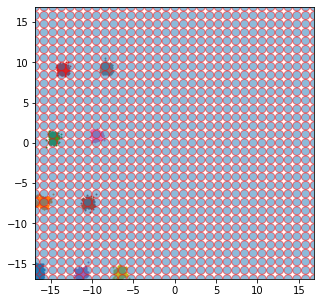

In [74]:
plot_config_wrap(Xtrain[0].reshape(-1,2),L=L)
for i in range(1,360,40):
    plt.scatter(Xtrain[::30,2*i], Xtrain[::30,2*i+1],s=1)

In [84]:
# [np.stack(fi.particles.position[:,:2].flatten() for fi in f[0:10]]

SyntaxError: invalid syntax (<ipython-input-84-41536ad3572d>, line 1)

In [99]:
f[0].particles.position[:,:2].flatten()

array([ 4.0933065,  4.0933065,  4.0933065, -3.0699801,  4.0933065,
       -2.0466535,  4.0933065, -1.0233268,  4.0933065,  0.       ,
        4.0933065,  1.0233268,  4.0933065,  2.0466535,  4.0933065,
        3.0699801, -3.0699801,  4.0933065, -3.0699801, -3.0699801,
       -3.0699801, -2.0466535, -3.0699801, -1.0233268, -3.0699801,
        0.       , -3.0699801,  1.0233268, -3.0699801,  2.0466535,
       -3.0699801,  3.0699801, -2.0466535,  4.0933065, -2.0466535,
       -3.0699801, -2.0466535, -2.0466535, -2.0466535, -1.0233268,
       -2.0466535,  0.       , -2.0466535,  1.0233268, -2.0466535,
        2.0466535, -2.0466535,  3.0699801, -1.0233268,  4.0933065,
       -1.0233268, -3.0699801, -1.0233268, -2.0466535, -1.0233268,
       -1.0233268, -1.0233268,  0.       , -1.0233268,  1.0233268,
       -1.0233268,  2.0466535, -1.0233268,  3.0699801,  0.       ,
        4.0933065,  0.       , -3.0699801,  0.       , -2.0466535,
        0.       , -1.0233268,  0.       ,  0.       ,  0.    

In [18]:
batchsize = 4000

### Train with the linear combination of two loss functions

In [15]:
def act(x):
    return -tf.nn.relu(x)

In [16]:
# reset model
#bg = invnet(model.dim, 'LRRRRRRRRRRRR', overlap_model=model, nl_layers=4, nl_hidden=200, #100
bg = invnet(model.dim, 'LRRRRRRRR', overlap_model=model, nl_layers=2, nl_hidden=50, #200, #100
#            nl_activation='tanh', nl_activation_t='tanh', L=L)
           nl_activation='tanh', nl_activation_t='relu', L=L)

L<RRRRRRRR>


In [19]:
hist_bg = bg.train_z(x=Xtrain[::1],epochs=10,lr=0.001,batch_size=batchsize)

Epoch 1/10
250/250 [==============================] - 13s 42ms/step - loss: 46.6379
Epoch 2/10
250/250 [==============================] - 11s 43ms/step - loss: -108.4557
Epoch 3/10
250/250 [==============================] - 11s 44ms/step - loss: -112.3753
Epoch 4/10
250/250 [==============================] - 11s 45ms/step - loss: -114.6429
Epoch 5/10
250/250 [==============================] - 11s 44ms/step - loss: -115.6685
Epoch 6/10
250/250 [==============================] - 11s 44ms/step - loss: -117.2026
Epoch 7/10
250/250 [==============================] - 11s 43ms/step - loss: -116.9657
Epoch 8/10
250/250 [==============================] - 11s 44ms/step - loss: -117.4725
Epoch 9/10
250/250 [==============================] - 11s 44ms/step - loss: -117.5877
Epoch 10/10
250/250 [==============================] - 11s 44ms/step - loss: -117.2726


In [20]:
hist_bg = bg.train_both(x=Xtrain[::1],epochs=10,lr=0.0001,batch_size=batchsize)

Epoch 1/10
250/250 [==============================] - 43s 156ms/step - loss: 2149.5294
Epoch 2/10
250/250 [==============================] - 39s 155ms/step - loss: 228.8928
Epoch 3/10
250/250 [==============================] - 39s 155ms/step - loss: 177.9341
Epoch 4/10
250/250 [==============================] - 39s 155ms/step - loss: 166.9734
Epoch 5/10
250/250 [==============================] - 39s 156ms/step - loss: 161.0048
Epoch 6/10
250/250 [==============================] - 39s 156ms/step - loss: 158.2794
Epoch 7/10
250/250 [==============================] - 39s 155ms/step - loss: 155.3413
Epoch 8/10
250/250 [==============================] - 39s 157ms/step - loss: 152.0709
Epoch 9/10
250/250 [==============================] - 39s 157ms/step - loss: 149.9784
Epoch 10/10
250/250 [==============================] - 39s 157ms/step - loss: 148.8094


In [50]:
hist_bg = bg.train_x(batches=100,epochs=10,lr=0.00003,batch_size=batchsize)

Epoch 1/10
100/100 [==============================] - 51s 490ms/step - loss: 10710.0182
Epoch 2/10
100/100 [==============================] - 53s 526ms/step - loss: 4874.3427
Epoch 3/10
100/100 [==============================] - 49s 493ms/step - loss: 2494.9248
Epoch 4/10
100/100 [==============================] - 50s 494ms/step - loss: 1693.7207
Epoch 5/10
100/100 [==============================] - 50s 497ms/step - loss: 1323.1391
Epoch 6/10
100/100 [==============================] - 49s 494ms/step - loss: 1021.2367
Epoch 7/10
100/100 [==============================] - 48s 478ms/step - loss: 874.0987
Epoch 8/10
100/100 [==============================] - 47s 471ms/step - loss: 809.9693
Epoch 9/10
100/100 [==============================] - 48s 480ms/step - loss: 776.9528
Epoch 10/10
100/100 [==============================] - 47s 472ms/step - loss: 758.1921


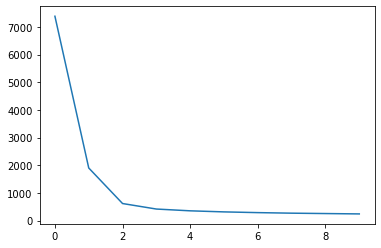

In [166]:
fig, ax = plt.subplots()
ax.plot(hist_bg.history['loss'])

In [167]:
print(tf.__version__)

2.4.0


In [21]:
a, sample_x, b, overlap_x, w, logw = bg.sample(nsample=10000, temperature=2)

[751.17426   0.        0.      ...   0.      336.35455  82.93927]


In [99]:
# np.zeros_like(sample_x[0:1])+0.2

In [100]:
# np.linalg.norm(a,axis=1)

In [101]:
# a[0]

In [603]:
# np.array([np.linalg.norm(a,axis=1),b]).T

array([[8.46199682e+00, 2.82544659e-16],
       [8.93540573e+00, 4.59879313e-18],
       [7.38280747e+00, 1.45950608e-12],
       [9.25789848e+00, 2.44678442e-19],
       [9.47650869e+00, 3.15690892e-20],
       [8.51270122e+00, 1.83734287e-16],
       [8.26341027e+00, 1.48706108e-15],
       [8.88630304e+00, 7.12308409e-18],
       [8.27129682e+00, 1.39319661e-15],
       [8.71533774e+00, 3.20717556e-17],
       [8.84716154e+00, 1.00784353e-17],
       [8.55810795e+00, 1.24701870e-16],
       [8.43262211e+00, 3.62119335e-16],
       [7.72598885e+00, 1.09215665e-13],
       [8.61404036e+00, 7.71449395e-17],
       [7.96473304e+00, 1.67817195e-14],
       [8.89756549e+00, 6.44429890e-18],
       [8.52382102e+00, 1.67129554e-16],
       [9.26625593e+00, 2.26453017e-19],
       [8.14351570e+00, 3.97630280e-15],
       [8.00222016e+00, 1.24411890e-14],
       [9.97902172e+00, 2.37841615e-22],
       [7.21056043e+00, 5.12910011e-12],
       [8.75973880e+00, 2.17588330e-17],
       [7.538664

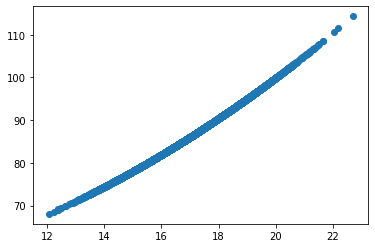

In [41]:
plt.scatter(np.linalg.norm(a,axis=1),b)

(array([2.148e+03, 5.710e+02, 5.610e+02, 5.540e+02, 5.060e+02, 4.880e+02,
        4.440e+02, 4.040e+02, 4.070e+02, 3.630e+02, 3.280e+02, 3.190e+02,
        2.770e+02, 2.370e+02, 2.310e+02, 2.100e+02, 1.860e+02, 1.550e+02,
        1.420e+02, 1.220e+02, 1.310e+02, 1.350e+02, 9.000e+01, 9.300e+01,
        8.400e+01, 6.500e+01, 5.700e+01, 6.600e+01, 5.500e+01, 4.900e+01,
        3.900e+01, 3.700e+01, 3.300e+01, 3.700e+01, 2.600e+01, 3.400e+01,
        3.100e+01, 3.300e+01, 1.400e+01, 1.700e+01, 1.500e+01, 1.000e+01,
        1.500e+01, 1.500e+01, 1.000e+01, 1.700e+01, 1.200e+01, 1.400e+01,
        4.000e+00, 5.000e+00, 1.300e+01, 2.000e+00, 7.000e+00, 7.000e+00,
        3.000e+00, 7.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 3.000e+0

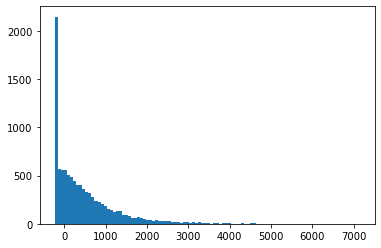

In [32]:
plt.hist(logw,bins=100)

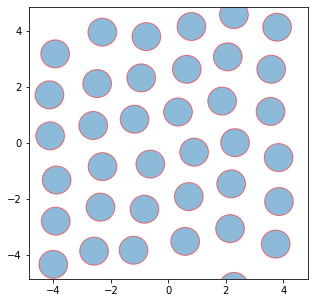

In [22]:
plot_config_wrap(model.wrap(bg.Tzx.predict(np.zeros_like(sample_x[0:1])+0.)).reshape(-1,2),L=L)

In [44]:
L/2

4.854064781389249

In [45]:
sample_x.min(),sample_x.max()

(-4.8538814, 4.853536)

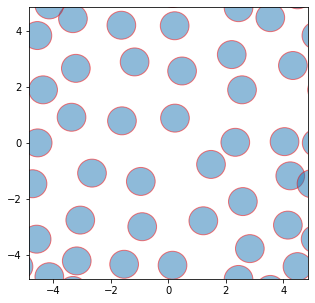

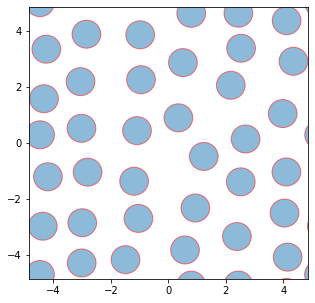

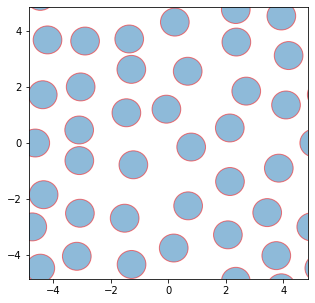

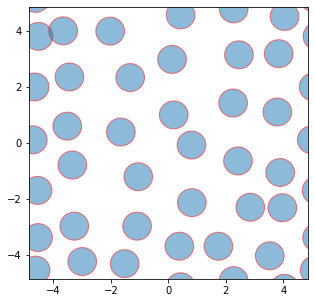

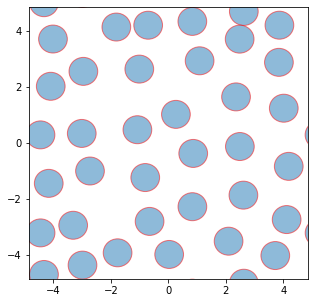

In [23]:
for i in range(5):
    plot_config_wrap(model.wrap(sample_x)[i:i+1].reshape(-1,2),L=L)

/opt/anaconda3/envs/BG/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

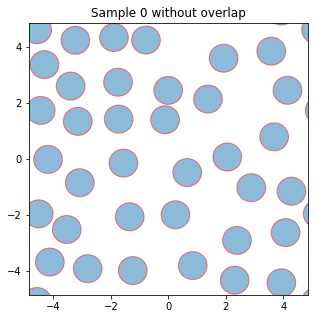

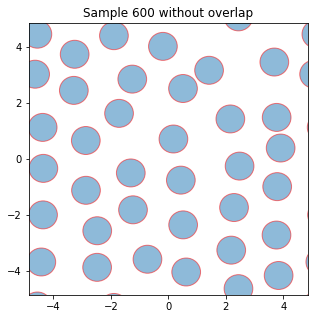

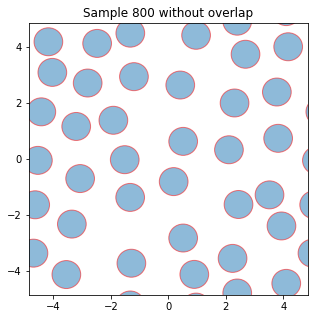

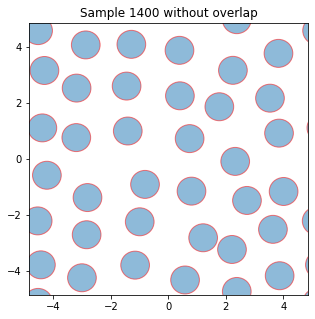

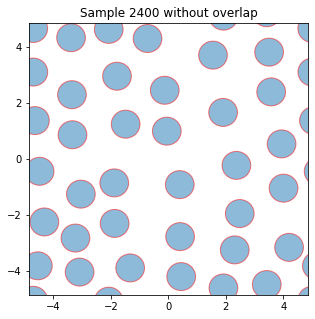

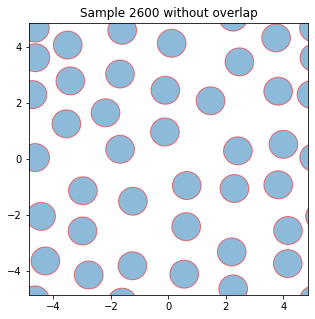

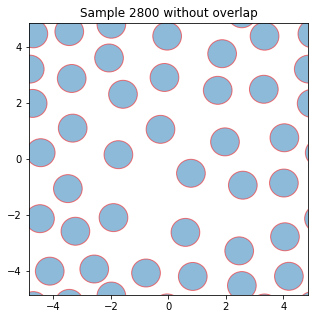

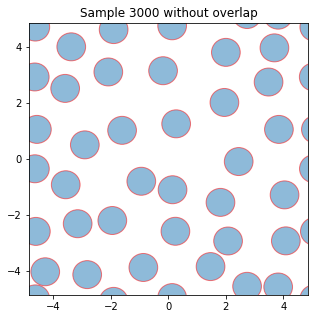

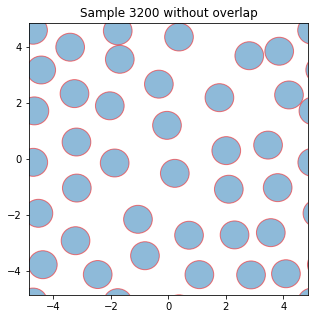

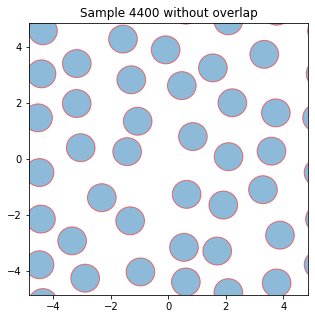

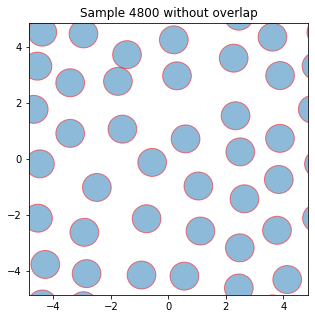

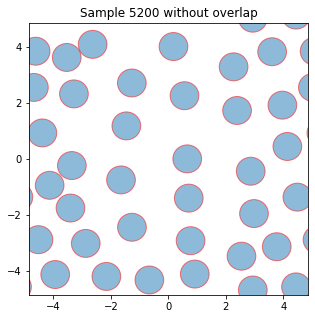

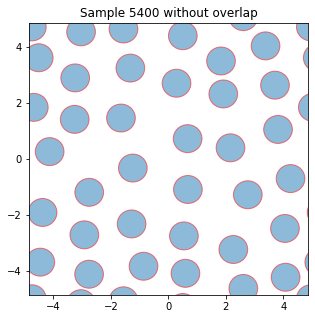

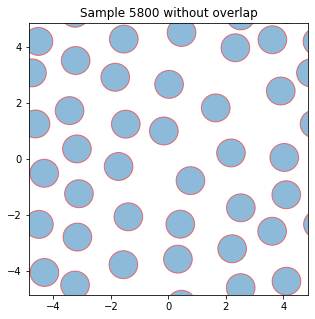

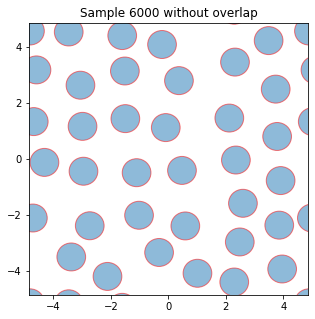

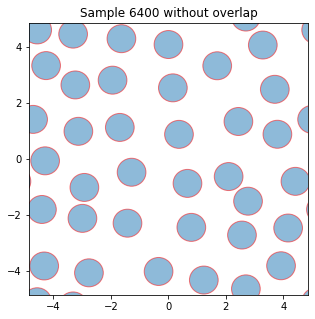

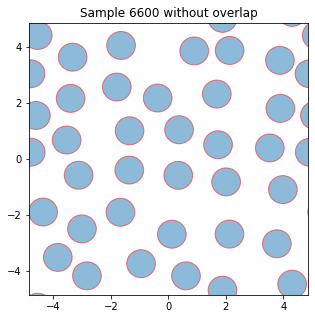

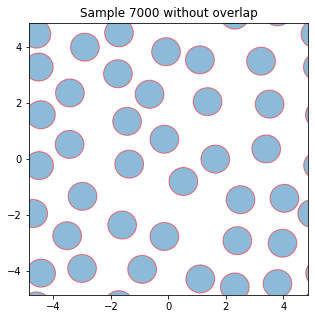

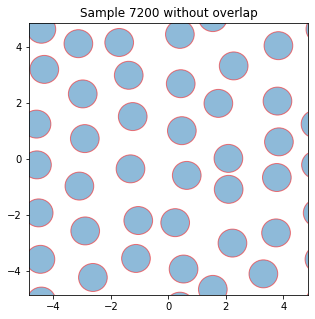

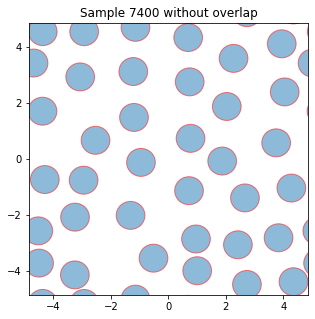

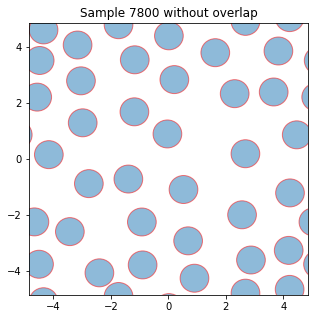

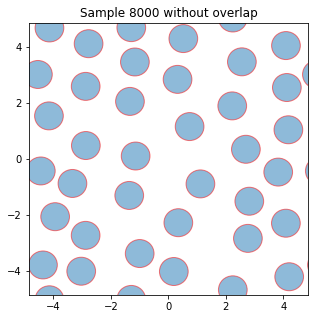

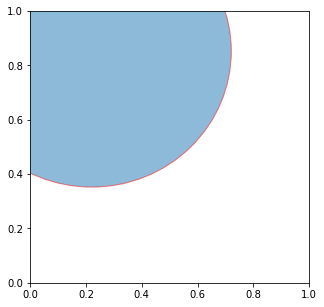

In [119]:
# plot_at_most = 50
# sts = (len(sample_x)//plot_at_most)
# for i in range(plot_at_most):
#     if model.smooth_overlap_tf(sample_x[i*sts:i*sts+1]) == 0:
#         plot_config_wrap(model.wrap(sample_x)[i*sts:i*sts+1].reshape(-1,2),L=L, title=f'Sample {i*sts} without overlap')

In [24]:
sum(model.smooth_overlap_tf(sample_x).numpy() == 0) / len(sample_x)

0.5111

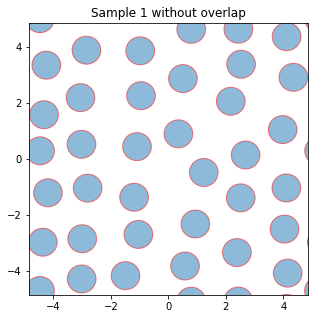

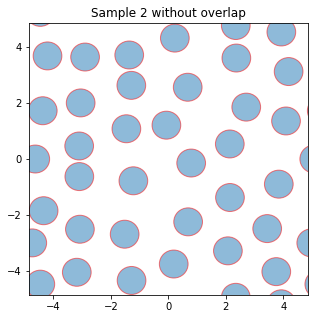

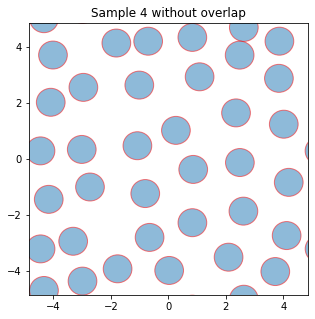

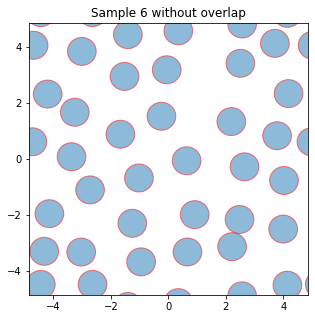

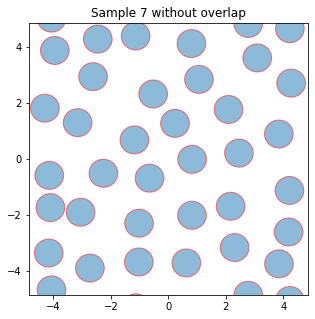

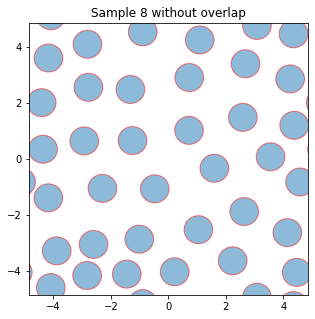

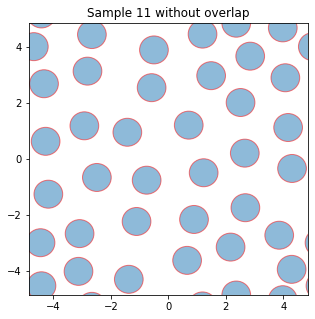

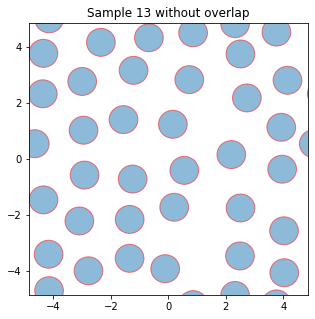

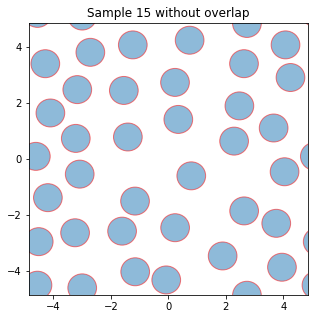

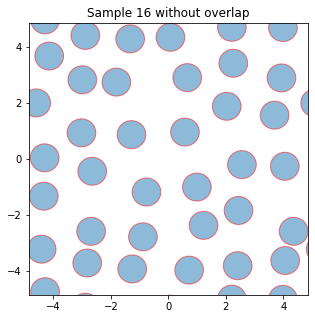

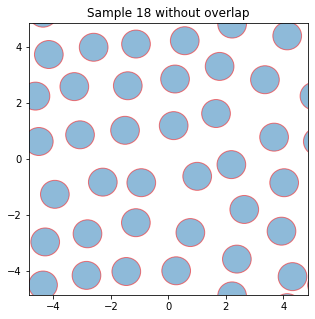

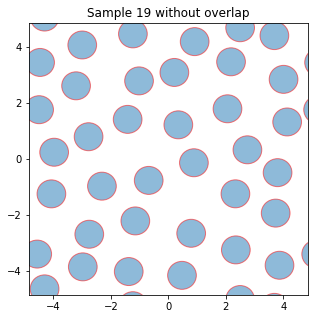

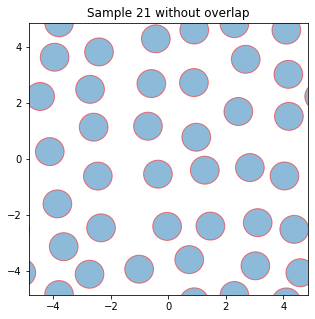

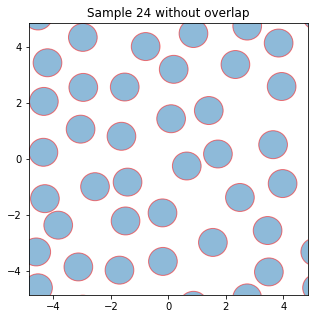

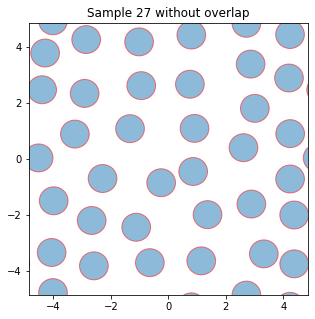

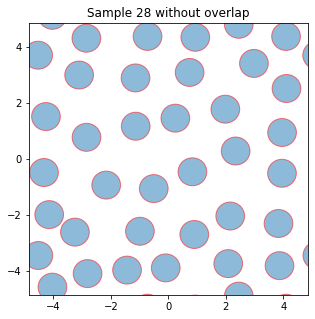

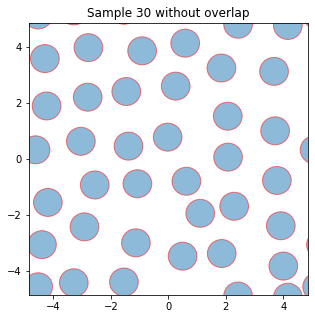

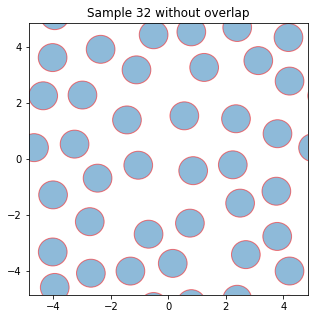

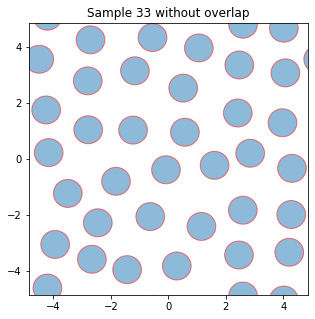

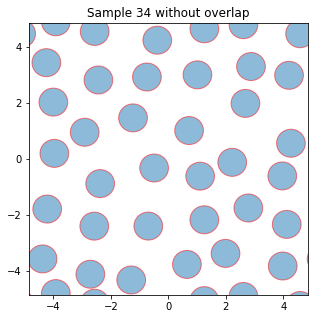

In [25]:
plot_at_most = 19
sts = (len(sample_x)//plot_at_most)
plotted = 0
for i in range(len(sample_x)):
    if model.smooth_overlap_tf(sample_x[i:i+1]) == 0:
        plot_config_wrap(model.wrap(sample_x)[i:i+1].reshape(-1,2),L=L, title=f'Sample {i} without overlap')
        plotted += 1
    if plotted > plot_at_most:
        break

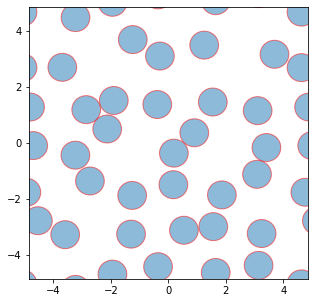

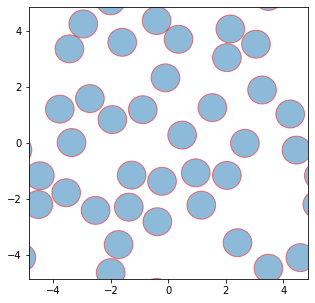

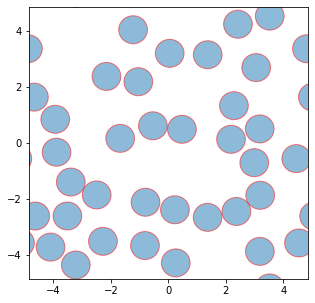

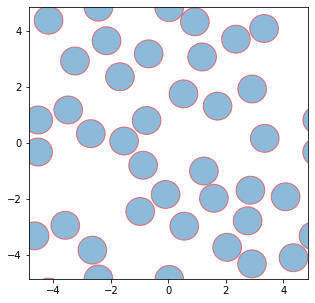

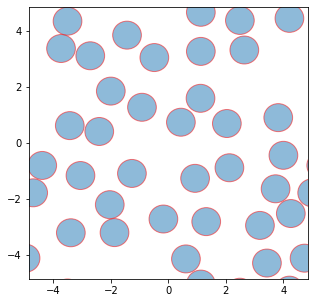

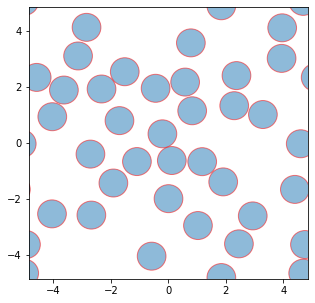

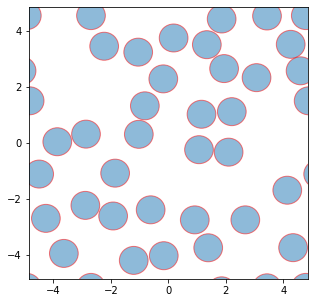

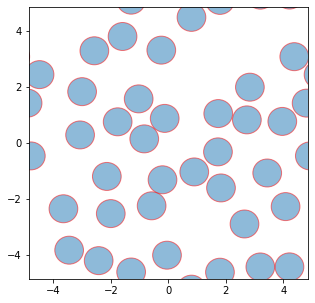

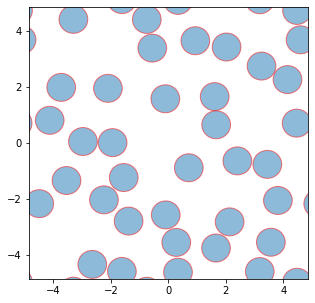

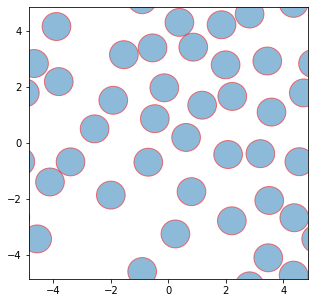

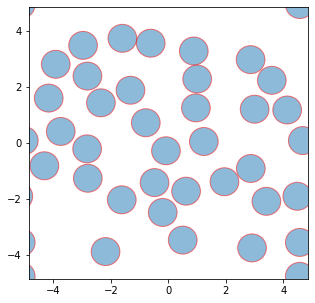

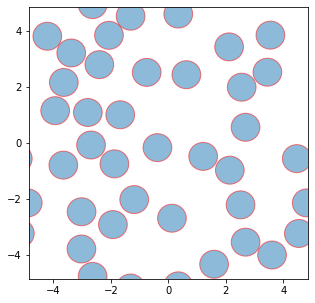

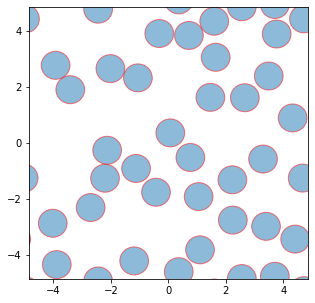

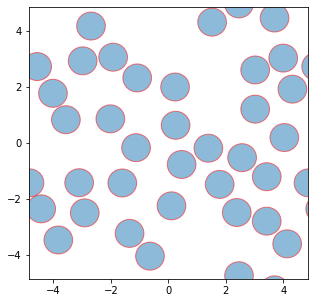

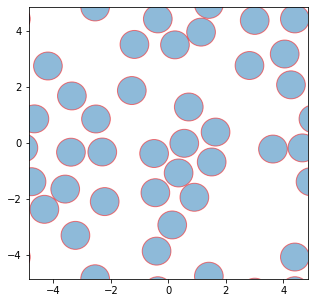

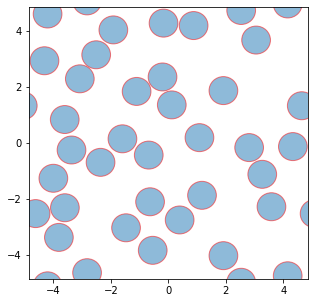

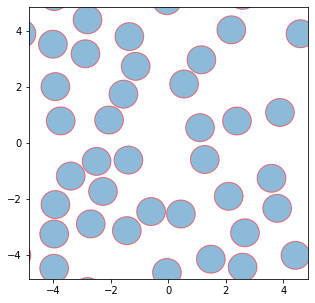

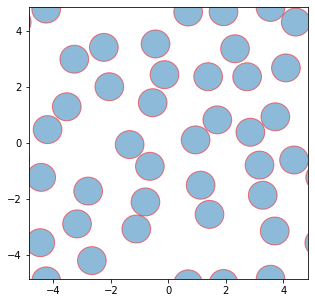

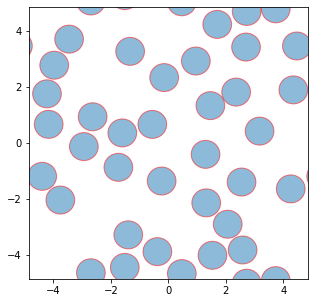

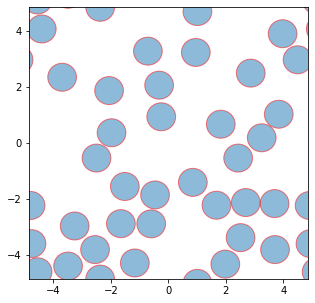

In [575]:
for i in range(20):
    plot_config_wrap(model.wrap(Xtrain_new[i*800:i*800+1]).reshape(-1,2),L=L)

(array([9.134e+03, 2.460e+02, 1.800e+02, 1.350e+02, 8.400e+01, 4.400e+01,
        2.600e+01, 2.900e+01, 1.700e+01, 1.800e+01, 1.100e+01, 9.000e+00,
        1.000e+01, 1.400e+01, 3.000e+00, 5.000e+00, 5.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

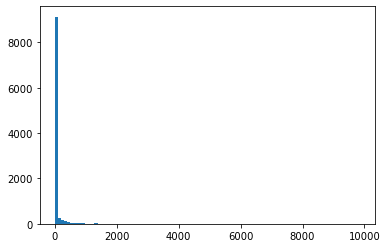

In [146]:
fig, ax = plt.subplots()
ax.hist(model.smooth_overlap_tf(sample_x).numpy(), bins=100)

/opt/anaconda3/envs/BG/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/envs/BG/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

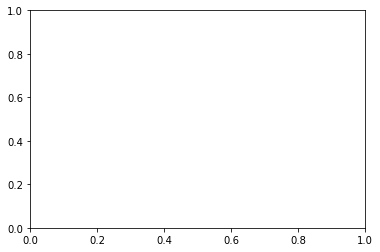

In [107]:
fig, ax = plt.subplots()
ax.hist(tf.keras.backend.eval(model.smooth_overlap_tf(sample_x)*w/tf.reduce_mean(w)),bins=20)
x = np.linspace(0,1000)

ax.set_yscale('log')

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ], dtype=float32),
 <BarContainer object of 20 artists>)

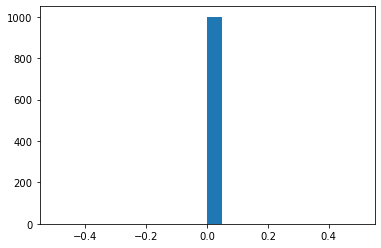

In [423]:
fig, ax = plt.subplots()
ax.hist(tf.keras.backend.eval(model.smooth_overlap_tf(Xtrain[0:1000])),bins=20)

In [427]:
np.array([f[-1].particles.position[:,:2].flatten(), Xtrain[-1]]).T

array([[ 0.70426345,  3.50787544],
       [ 3.59875178,  4.00698233],
       [ 0.66067493,  3.8949368 ],
       [-0.55142546, -4.13938951],
       [ 2.70731091,  4.798419  ],
       [-2.20287609, -2.57125878],
       [ 1.05227089,  4.02671719],
       [ 2.57348919, -1.51185513],
       [-2.39799094,  4.40564632],
       [-2.09704113, -0.10306334],
       [ 1.71431649,  4.08311272],
       [-1.5266993 ,  2.52854395],
       [ 4.798419  , -4.17038774],
       [-2.57125878,  4.70190287],
       [-3.92576528, -3.74221063],
       [-1.51659548, -3.81480908],
       [-0.9295913 , -2.59081316],
       [-0.00864144, -3.09157872],
       [ 4.02671719, -3.92576528],
       [-1.51185513, -1.51659548],
       [ 2.86907482, -4.14851284],
       [ 1.17682588,  0.75898933],
       [-0.87459266, -4.33959293],
       [-2.78883696,  3.30661368],
       [ 4.08311272, -1.9466269 ],
       [ 2.52854395,  2.85835433],
       [ 4.40564632, -0.78210586],
       [-0.10306334, -4.76854944],
       [-1.65577376,

In [436]:
def plot_config_wrap_num(pts,L=1,title=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    pts_addl = []
    for p in pts:
        if p[0] < -L/2+0.5:
            pts_addl.append([p[0]+L, p[1]])  
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]+L, p[1]-L])
        if p[0] > -L/2+0.5:
            pts_addl.append([p[0]-L, p[1]])
            if p[1] < -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]+L])
            if p[1] > -L/2+0.5:
                pts_addl.append([p[0]-L, p[1]-L])
        if p[1] < -L/2+0.5:
            pts_addl.append([p[0], p[1]+L])
        if p[1] > -L/2+0.5:
            pts_addl.append([p[0], p[1]-L])
        
    circles = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts]
    circles2 = [plt.Circle(p,.5,alpha=0.5,ec='red') for p in pts_addl]
    for idx, c in enumerate(circles):
        ax.add_patch(c)
        plt.text(pts[idx][0],pts[idx][1],f'{idx}')
    for c in circles2:
        ax.add_patch(c)
    ax.set_xlim(-L/2,L/2)
    ax.set_ylim(-L/2,L/2)
    if title is not None:
        ax.set_title(title)

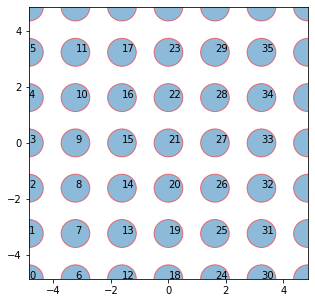

In [439]:
plot_config_wrap_num(model.wrap(f[0].particles.position),L=L)

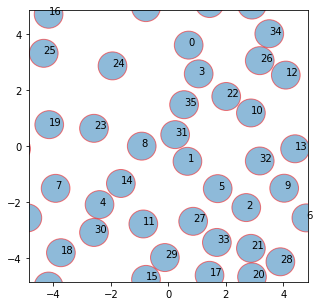

In [438]:
plot_config_wrap_num(model.wrap(f[-1].particles.position),L=L)

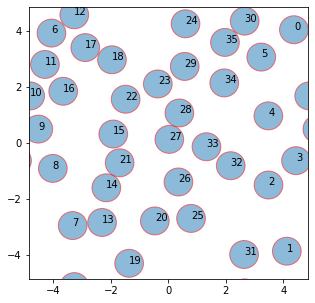

In [544]:
plot_config_wrap_num(Xtrain_new[100].reshape(-1,2),L=L)

In [531]:
Xtest = Xtrain[0].reshape(-1,2)

In [532]:
dist_frac(Xtest,1.1)

0.0

In [526]:
dist_frac_array = np.zeros((len(Xtrain)))
for i in range(len(Xtrain)):
#     if i % 1000 == 0:
#         print(dist_frac(Xtrain[i].reshape(-1,2),4))
    dist_frac_array[i] = dist_frac(Xtrain[i].reshape(-1,2),1.1)

In [539]:
(dist_frac_array > 0.4).sum()


18732

In [540]:
Xtrain_new = Xtrain[dist_frac_array>0.4]

In [541]:
np.where(dist_frac_array > 0.4)

(array([   71,    72,    77, ..., 99987, 99988, 99999]),)

(array([6.6600e+02, 3.7180e+03, 1.8164e+04, 1.9337e+04, 3.1032e+04,
        1.9559e+04, 5.1840e+03, 2.1120e+03, 2.1200e+02, 1.6000e+01]),
 array([0.   , 0.075, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
        0.675, 0.75 ]),
 <BarContainer object of 10 artists>)

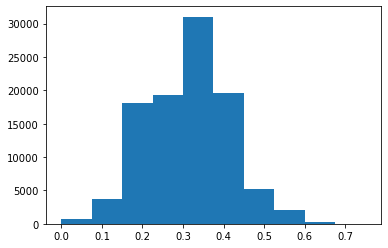

In [534]:
plt.hist(dist_frac_array)

In [520]:
def dist_frac(Xtest, thres=5):
    dist_mat = ((Xtest[:,:,None] - Xtest[:,:,None].T)**2).sum(1)
    dist_mat[dist_mat == 0] = 999
#     print(dist_mat)
#     print(np.min(dist_mat, axis=1))
    dist_mat = np.sqrt(np.min(dist_mat, axis=1)).flatten()
#     print(dist_mat)
    return np.sum(dist_mat < thres) / len(Xtest)

In [55]:
phi = 0.3 # packing fraction
sigma = 1
N = 2
L = (N*(np.pi*0.25*sigma**2)/phi)**0.5
model2 = HardDisks(N=2,
                  L=L,
                  sigma=sigma,
                  eps=1500)

In [61]:
model2.smooth_overlap_tf(np.array([[0.0,0.0,0.0,1.5]])).numpy()

array([635.3159], dtype=float32)

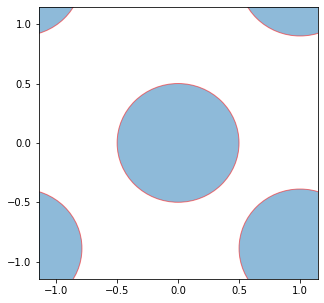

In [68]:
plot_config_wrap(np.array([[0.0,0.0,1.0,1.4]]).reshape(-1,2), L=L)

In [92]:
def log1pexp(x):
  return tf.math.log(1 + tf.exp(x))

In [93]:
log1pexp(tf.constant(3.)).numpy()

3.0485873

In [94]:
x = tf.Variable(100.)

with tf.GradientTape() as tape:
    y = log1pexp(x)
#     dy = tf.GradientTape(y, x) # Will be NaN when evaluated.

dy_dx = tape.gradient(y, x)


In [95]:
print(dy_dx)

tf.Tensor(nan, shape=(), dtype=float32)


In [96]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

In [97]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    y = log1pexp(x)
dy_dx = tape.gradient(y, x)

In [98]:
print(dy_dx)

tf.Tensor(1.0, shape=(), dtype=float32)
